# ICNN Initialization

As input convex neural networks (ICNN) are notoriously difficult to train {cite}`richter-powell:21`, {cite}`bunne:22` propose to use closed-form solutions between Gaussian approximations to derive relevant parameter initializations for ICNNs: given two measures $\mu$ and $\nu$, one can initialize ICNN parameters so that its gradient can map approximately $\mu$ into $\nu$. These initializations rely on closed-form solutions available for Gaussian measures {cite}`gelbrich:90`.

In this notebook, we introduce the *identity* and *Gaussian approximation*-based initialization schemes, and illustrate how they can be used within the `OTT` library when using {class}`~ott.neural.networks.icnn.ICNN`-based  potentials with the {class}`~ott.neural.methods.neuraldual.W2NeuralDual` solver.

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import optax

import matplotlib.pyplot as plt

from ott import datasets
from ott.geometry import pointcloud
from ott.neural.methods import neuraldual
from ott.neural.networks import icnn
from ott.tools import plot

## Setup training and validation datasets

To test the ICNN initialization methods, we choose the {class}`~ott.neural.methods.neuraldual.W2NeuralDual` of the `OTT` library as an example. Here, we aim at computing the map between two toy datasets representing both, source and target distribution using the
datasets `simple` (data clustered in one center) and `circle` (two-dimensional Gaussians arranged on a circle) from {class}`~ott.datasets.create_gaussian_mixture_samplers`.
For more details on the execution of the {class}`~ott.neural.methods.neuraldual.W2NeuralDual`, we refer the reader to {doc}`neural_dual` notebook.

## Experimental setup 

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.
The following command loads them with OTT's pre-packaged loader for synthetic data.

In [3]:
num_samples_visualize = 400
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = datasets.create_gaussian_mixture_samplers(
    name_source="simple",
    name_target="circle",
    train_batch_size=num_samples_visualize,
    valid_batch_size=num_samples_visualize,
)

To visualize the initialization schemes, let's sample data from the source and target distribution.

In [4]:
data_source = next(train_dataloaders.source_iter)
data_target = next(train_dataloaders.target_iter)

In [5]:
# initialize optimizers
optimizer_f = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)
optimizer_g = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)

### Identity initialization method

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. These need to be parameterized by ICNNs. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can solve the problem using approximations to this positivity constraint (via weight clipping and a weight penalization).
For this, set `pos_weights` to `True` in {class}`~ott.neural.networks.icnn.ICNN` and {class}`~ott.neural.methods.neuraldual.W2NeuralDual`.
For more details on how to customize {class}`~ott.neural.networks.icnn.ICNN`,
we refer you to the documentation.

We first explore the `identity` initialization method. This initialization method is the default choice of the current ICNN and data independent, thus no further arguments need to be passed to the ICNN architecture.

In [6]:
# initialize models using identity initialization (default)
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)

In [7]:
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0
)
learned_potentials = neural_dual_solver(*train_dataloaders, *valid_dataloaders)

/Users/michal/Projects/dott/src/ott/neural/methods/neuraldual.py:154: UserWarning: Setting of ICNN and the positive weights setting of the `W2NeuralDual` are not consistent. Proceeding with the `W2NeuralDual` setting, with positive weights being True.
  self.setup(


0it [00:00, ?it/s]

Now, we can plot the corresponding transport from source to target using the gradient of the learning potential $f$, i.e., $\nabla f(\text{source})$, or from target to source via the gradient of the learning potential $g$, i.e., $\nabla g(\text{target})$.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

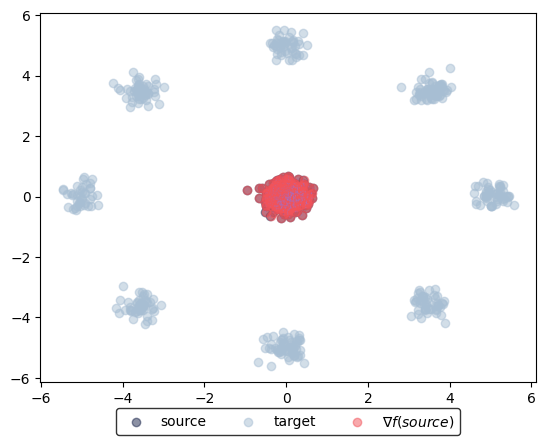

In [8]:
learned_potentials.plot_ot_map(data_source, data_target, forward=True)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

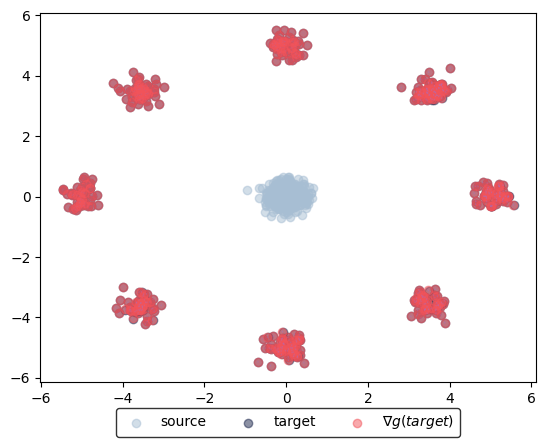

In [9]:
learned_potentials.plot_ot_map(data_source, data_target, forward=False)

Before training, the `identity` initialization (`num_train_iters=0`) maps source or target sample onto itself. If source and target samples are not too dissimilar, this initialization method compared to a random vanilla weight initialization achieves a good approximation already.

### Gaussian initialization

The Gaussian approximation-based initialization schemes require samples from both, source and target distributions, in order to initialize the ICNNs with linear factors and means, as detailed in {cite}`bunne:22`.

In [10]:
samples_source = next(train_dataloaders.source_iter)
samples_target = next(train_dataloaders.target_iter)

To use the Gaussian initialization, the samples of source and target (`samples_source` and `samples_target`) need to be passed to the {class}`~ott.neural.networks.icnn.ICNN` definition via the `gaussian_map_samples` argument. Note that ICNN $f$ maps source to target (`gaussian_map_samples=(samples_source, samples_target)`), and $g$ maps target to source cells (`gaussian_map_samples=(samples_target, samples_source)`).

In [11]:
# initialize models using Gaussian initialization
neural_f = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map_samples=(samples_source, samples_target),
)
neural_g = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map_samples=(samples_target, samples_source),
)

In [12]:
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0
)
learned_potentials = neural_dual_solver(*train_dataloaders, *valid_dataloaders)

/Users/michal/Projects/dott/src/ott/neural/methods/neuraldual.py:154: UserWarning: Setting of ICNN and the positive weights setting of the `W2NeuralDual` are not consistent. Proceeding with the `W2NeuralDual` setting, with positive weights being True.
  self.setup(


0it [00:00, ?it/s]

Again, we can plot the corresponding transport from source to target using the gradient of the learning potential $f$, i.e., $\nabla f(\text{source})$, or from target to source via the gradient of the learning potential $g$, i.e., $\nabla g(\text{target})$.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

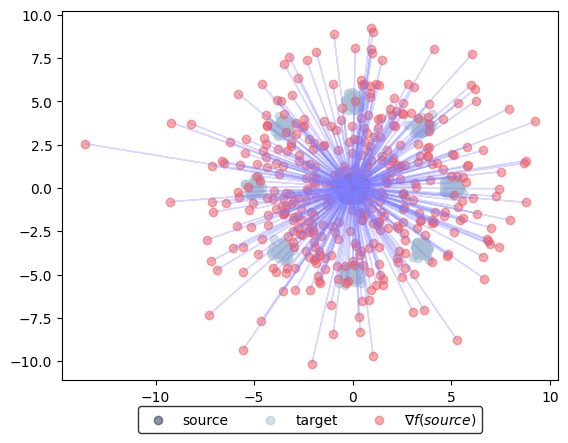

In [13]:
learned_potentials.plot_ot_map(data_source, data_target, forward=True)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

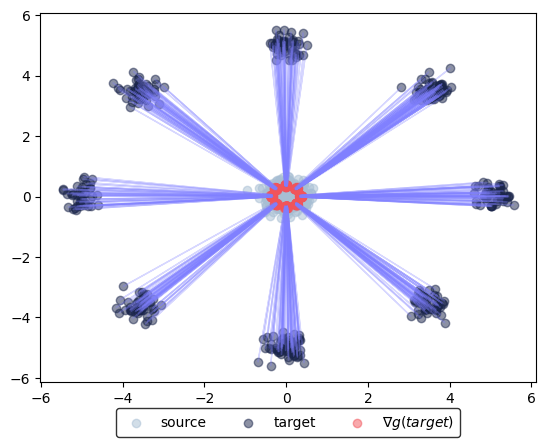

In [14]:
learned_potentials.plot_ot_map(data_source, data_target, forward=False)

Using this initialization scheme maps the source (using $f$) or target measure (using $g$) to the Gaussian approximation of the respective counterpart. In the case of target $\nu$ this represents almost the correct solution.